# Mean meteorological variables calculation

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xarray as xr 
import salem
from glob import glob
import seaborn as sns

import sys
sys.path.insert(1, '../src/')
from scripts.functions import add_shape_coord_from_data_array, rasterize, transform_from_latlon
%matplotlib inline

In [28]:
def prepare_GOES(path):
    ds = xr.open_dataset(path)
    ds['longitudes'] = ds.longitudes[0]
    ds['latitudes'] = ds.latitudes[:, 0]
    ds = ds.set_coords(['longitudes', 'latitudes'])
    ds.attrs['pyproj_srs'] = 'epsg:4326'
    ds = ds.rename({'longitudes':'longitude', 'latitudes':'latitude'})
    ds = ds.swap_dims({'x':'longitude', 'y':'latitude'})
    return ds

def prepare_IMERG_tiff(path):
    ds = xr.open_rasterio(path)
    ds = ds.rename({'x':'longitude', 'y':'latitude'})
    return ds

def prepare_UVtermis(path):
    ds = xr.open_dataset(path)
    ds = ds.rename({'Latitudes':'latitude', 'Longitudes':'longitude'})
    ds = ds.swap_dims({'fakeDim0':'latitude', 'fakeDim1':'longitude'})
    ds = ds.set_coords(['longitude', 'latitude'])
    ds.attrs['pyproj_srs'] = 'epsg:4326'
    ds['UVI_field'] = ds.UVI_field * ds.UVI_scale_factor
    return ds

def prepare_UVdose_cloudfree(path):
    ds = xr.open_dataset(path)
    ds = ds.rename({'Latitudes':'latitude', 'Longitudes':'longitude'})
    ds = ds.swap_dims({'fakeDim0':'latitude', 'fakeDim1':'longitude'})
    ds = ds.set_coords(['longitude', 'latitude'])
    ds.attrs['pyproj_srs'] = 'epsg:4326'
    ds['UVD_cloud-free'] = ds['UVD_cloud-free'] * ds.UVD_scale_factor
    return ds

def prepare_UVdose_cloudmodified(path):
    ds = xr.open_dataset(path)
    ds = ds.rename({'Latitudes':'latitude', 'Longitudes':'longitude'})
    ds = ds.swap_dims({'fakeDim0':'latitude', 'fakeDim1':'longitude'})
    ds = ds.set_coords(['longitude', 'latitude'])
    ds.attrs['pyproj_srs'] = 'epsg:4326'
    ds['UVD_cloud-modified'] = ds['UVD_cloud-modified'] * ds.UVD_scale_factor
    return ds

In [29]:
shp_dir = '../src/data/vector/departamentos_colombia.shp'
shp = salem.read_shapefile(shp_dir)
shp.Name = ['Bolivar', 'Boyaca', 'Caldas', 'Caqueta', 'Cauca', 'Cesar', 'Cordoba', 'Cundinamarca', 'Choco', 'Huila', 'La Guajira', 'Magdalena', 'Meta', 'Nariño', 'Norte de Santander', 'Quindio', 'Risaralda', 'Santander', 'Sucre', 'Tolima', 'Valle del Cauca', 'Arauca', 'Casanare', 'Putumayo', 'San Andres y Providencia', 'Amazonas', 'Guainia', 'Guaviare', 'Vaupes', 'Vichada', 'NN', 'Antioquia', 'Atlantico', 'Bogota']
nombres_mascara = shp.Name

# BT GOES

In [4]:
paths = glob('../src/data/GOES/brightness_temperature/*nc')

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[0]
ds = prepare_GOES(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mascara = ds_masked.departamentos

for path in paths[:]:
    
    ds = prepare_GOES(path)
    
    for id_municipio in nombres_mascara.index:
        select = ds.where(mascara == id_municipio, other=np.nan).bt_promedio.values
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('_')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

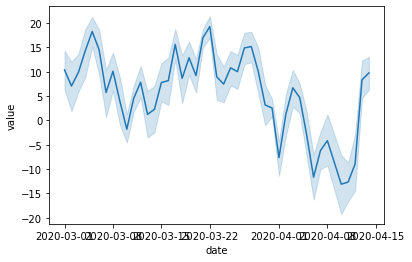

In [5]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [6]:
data_meteo.to_csv('../src/data/series/GOES_bt.csv')

# Cloud cover

In [10]:
paths = glob('../src/data/GOES/cloud_cover/*nc')
paths = [path for path in paths if len(path) < max([len(path) for path in paths])]

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[1]
ds = prepare_GOES(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [11]:
for path in paths[1:]:
    ds = prepare_GOES(path)
    
    for id_municipio in nombres_mascara.index:
        select = ds.where(mask == id_municipio, other=np.nan).porcentaje.values
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('_')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

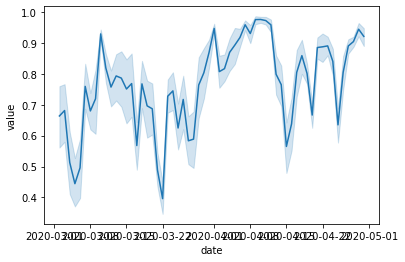

In [12]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [13]:
data_meteo.to_csv('../src/data/series/GOES_cc.csv')

# IMERG

In [18]:
paths = glob('../src/data/IMERG/*tiff')

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[1]
ds = prepare_IMERG_tiff(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [19]:
for path in paths[:]:
    ds = prepare_IMERG_tiff(path)
    
    for id_municipio in nombres_mascara.index:
        select = ds.where(mask == id_municipio, other=np.nan).values
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('_')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

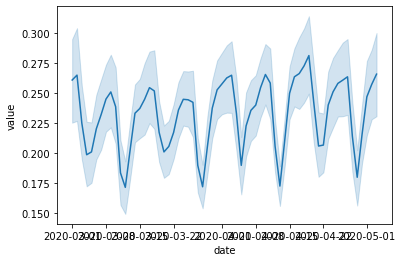

In [20]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [21]:
data_meteo.to_csv('../src/data/series/IMERG.csv')

# ERA 5

In [105]:
data_meteo = {var:pd.DataFrame(columns = nombres_mascara.values) for var in ['t2m_max', 't2m_min', 't2m_mean', 'ssr_sum', 'ssr_mean', 'uv_mean']}
ds = xr.open_dataset('../src/data/ERA5/ERA5_desccarga.nc')

for var in ds.data_vars:
     ds[var][744:, 0, :, :] = ds[var][744:, 1, :, :] 

ds['time'] = ds['time'] - pd.Timedelta('5h')


In [106]:
dates = pd.to_numeric(pd.to_datetime(ds['time'][:].values).strftime('%Y%m%d'))

In [107]:
#create mask
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [108]:
operation = ['nanmax', 'nanmin', 'nanmean', 'nansum', 'nanmean', 'nanmean']
data_vars = ['t2m', 't2m', 't2m', 'ssr', 'ssr', 'uv']

In [109]:
np.warnings.filterwarnings('ignore')

for var, oper in zip(data_vars, operation):
    print(var)
    for date in dates.unique():
#         print(date)
        for id_municipio in nombres_mascara.index:
            
            if var != 'uv':
                select = getattr(np, oper)(ds.where(mask == id_municipio, other=np.nan)[var][np.where(dates == date)[0], 0, :, :].values, axis = 0)
                select = select[np.isfinite(select)]

                if len(select) > 0:
                    mean = np.nanmean(select)
                else:
                    mean = np.nan
            
            elif var == 'uv': 
                select = np.nanmean(np.sqrt(ds.where(mask == id_municipio, other=np.nan)['u10'][np.where(dates == date)[0], 0, :, :].values**2 + ds.where(mask == id_municipio, other=np.nan)['v10'][np.where(dates == date)[0], 0, :, :].values**2), axis = 0)
                select = select[np.isfinite(select)]

                if len(select) > 0:
                    mean = np.nanmean(select)
                else:
                    mean = np.nan
                    
            data_meteo[var + '_' + oper.replace('nan', '')].loc[pd.to_datetime(str(date)), nombres_mascara[id_municipio]] = mean

t2m
t2m
t2m
ssr
ssr
uv


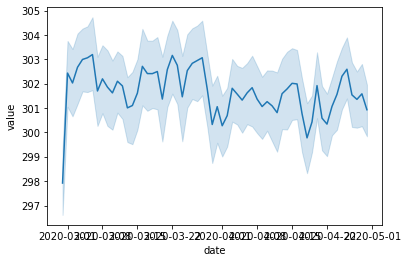

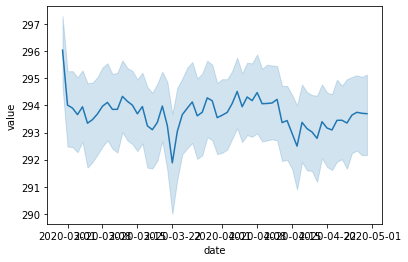

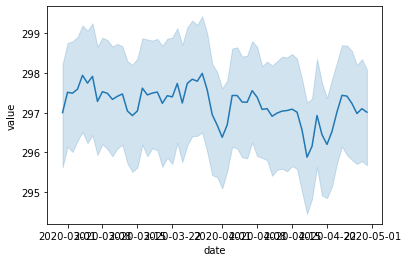

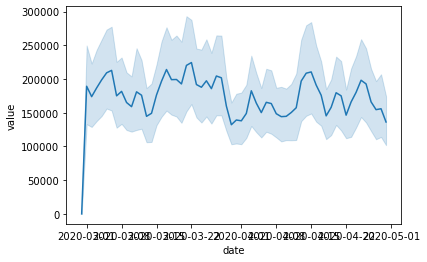

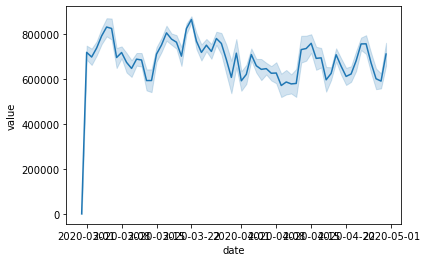

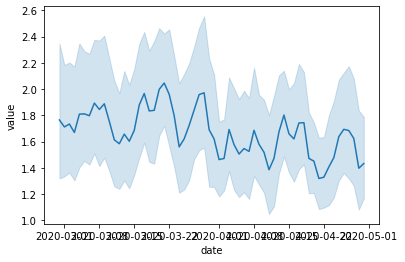

In [119]:
for var in data_meteo:
    plt.figure()
    sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo[var].astype(float).reset_index(), ['index']).rename(columns = {'index':'date'}))
    data_meteo[var].to_csv('../src/data/series/%s.csv'%('ERA5_' + var))


# UV Temis

In [24]:
ds = prepare_UVtermis(path)

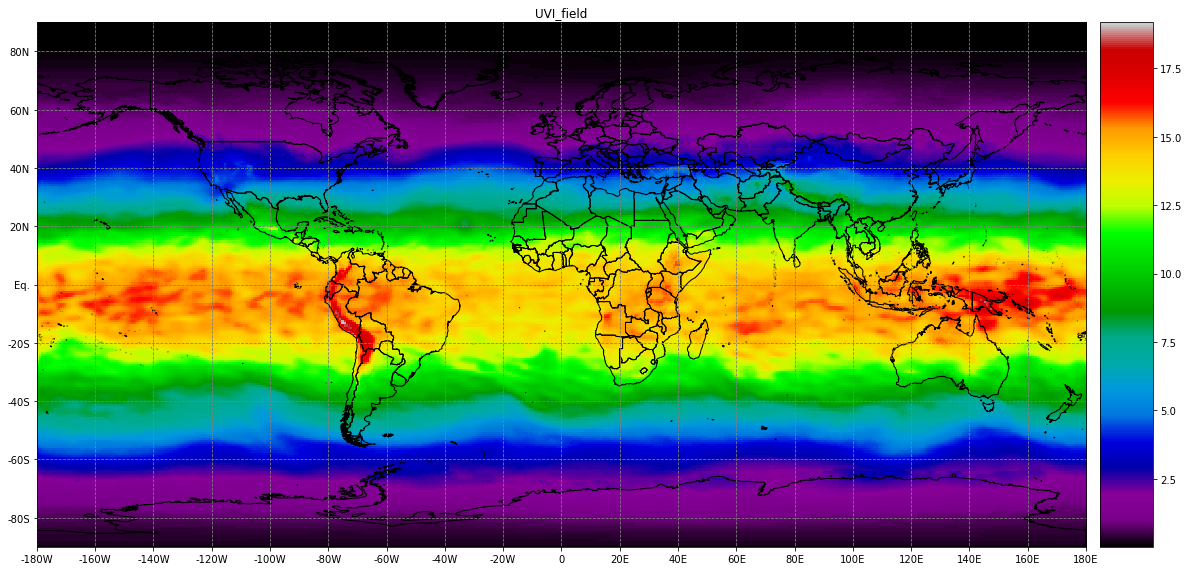

In [26]:
plt.figure(figsize=(20,14))
ds.UVI_field.salem.quick_map(cmap = plt.cm.nipy_spectral)

In [5]:
paths = glob('../src/data/UV_Temis/*.h5')

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[1]
ds = prepare_UVtermis(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

In [11]:
ds = prepare_UVtermis(path)

for id_municipio in nombres_mascara.index:
    select = ds.where(mask == id_municipio, other=np.nan).UVI_field.values

In [ ]:
%%time
for path in paths[:]:
    ds = prepare_UVtermis(path)

    for id_municipio in nombres_mascara.index:
        select = ds.where(mask == id_municipio, other=np.nan).UVI_field.values
#         select = select.astype(float)
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('uvief')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

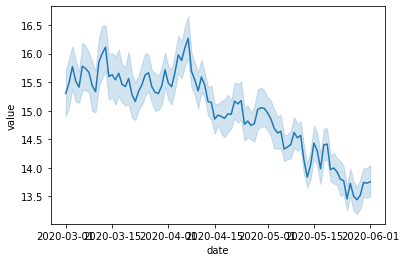

In [100]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [101]:
data_meteo.to_csv('../src/data/series/UV.csv')

# UD Dose

In [35]:
paths = glob('../src/data/UV_dose/*h5')

data_meteo = pd.DataFrame(columns = nombres_mascara.values)

path = paths[1]
ds = prepare_UVdose_cloudfree(path)
ds_masked = add_shape_coord_from_data_array(ds, shp_dir, "departamentos")
mask = ds_masked.departamentos

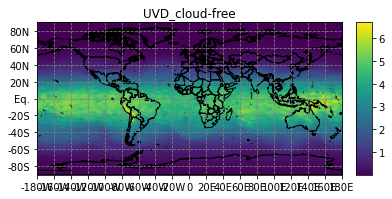

In [36]:
ds_masked.salem.quick_map('UVD_cloud-free')

In [38]:
path

'../src/data/UV_dose\\uvddc20200301.h5'

In [39]:
%%time
for path in paths[:]:
    ds = prepare_UVdose_cloudfree(path)

    for id_municipio in nombres_mascara.index:
        select = ds.where(mask == id_municipio, other=np.nan)['UVD_cloud-free'].values
#         select = select.astype(float)
        
        select = select[np.isfinite(select)]
        
        if len(select) > 0:
            mean = np.nanmean(select)
        else:
            mean = np.nan
            
        data_meteo.loc[pd.to_datetime(path.split('uvddc')[-1].split('.')[0]), nombres_mascara[id_municipio]] = mean

data_meteo = data_meteo.astype(float)

Wall time: 8min 6s


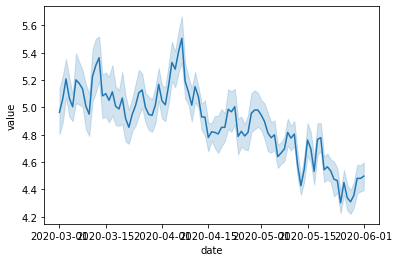

In [40]:
sns.lineplot(x = 'date', y = 'value', data = pd.melt(data_meteo.reset_index(), ['index']).rename(columns = {'index':'date'}))

In [42]:
data_meteo.to_csv('../src/data/series/UV_dose.csv')

### Descarga de UV Temis

In [42]:
base_url = 'http://www.temis.nl/uvradiation/archives/v2.0/{year}/{month}/uvief{date}.hdf'
dates_uv = pd.date_range('2020-03-01', '2020-06-01', freq = 'd')

for date in dates_uv:
    print(base_url.format(year = date.strftime('%Y'), month = date.strftime('%m'), date = date.strftime('%Y%m%d')))

In [2]:
import pandas as pd

In [3]:
base_url = 'http://www.temis.nl/uvradiation/archives/v2.0/{year}/{month}/uvddc{date}.hdf'
dates_uv = pd.date_range('2020-03-01', '2020-06-01', freq = 'd')

for date in dates_uv:
    print(base_url.format(year = date.strftime('%Y'), month = date.strftime('%m'), date = date.strftime('%Y%m%d')))

http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200301.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200302.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200303.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200304.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200305.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200306.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200307.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200308.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200309.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200310.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200311.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200312.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200313.hdf
http://www.temis.nl/uvradiation/archives/v2.0/2020/03/uvddc20200